<a href="https://colab.research.google.com/github/labviros/computer-vision-topics/blob/version2020/lesson06-camera_calibration/camera_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Camera Calibration



#Complementary functions

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
import zipfile

########################################################
# Complementary functions for ploting points and vectors with Y-axis swapped with Z-axis
def set_plot(ax=None,figure = None,figsize=(9,8),limx=[-2,2],limy=[-2,2],limz=[-2,2]):
    if figure ==None:
        figure = plt.figure(figsize=(9,8))
    if ax==None:
        ax = plt.axes(projection='3d')

    ax.set_title("Camera Calibration")
    ax.set_xlim(limx)
    ax.set_xlabel("x axis")
    ax.set_ylim(limy)
    ax.set_ylabel("y axis")
    ax.set_zlim(limz)
    ax.set_zlabel("z axis")
    return ax

#adding quivers to the plot
def draw_arrows(point,base,axis,length=1.5):
    # Plot vector of x-axis
    axis.quiver(point[0],point[1],point[2],base[0,0],base[1,0],base[2,0],color='red',pivot='tail',  length=length)
    # Plot vector of y-axis
    axis.quiver(point[0],point[1],point[2],base[0,1],base[1,1],base[2,1],color='green',pivot='tail',  length=length)
    # Plot vector of z-axis
    axis.quiver(point[0],point[1],point[2],base[0,2],base[1,2],base[2,2],color='blue',pivot='tail',  length=length)

    return axis
#########################################################

#Read images and detect features


In [ ]:
# Read zip file and unzip images

zip_ref = zipfile.ZipFile('./imgs.zip','r')
zip_ref.extractall('./')
zip_ref.close()

# Termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Chessboard parameters
square_size = 50
# l - lines, c - columns
l=10
c=7

# prepare 3D object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((l*c,3), np.float32)
objp[:,:2] = np.mgrid[0:c*square_size:square_size,0:l*square_size:square_size].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Read images for calibration
images = glob.glob('./imgs/*.jpg')
# Print the number of images to see if all of them were read
print('Number of images read: ', len(images))

# Read images, detect the corners, refine to subpixel precision and plot the detected corners
for fname in images:
    # Read image and convert to grayscale
    img = cv2.imread(fname)
    # Verify if the image has landscape format. If not, rotate image
    imsize = img.shape
    print('Image size: ', imsize[0], ' ',imsize[1])
    if (imsize[1] < imsize[0]):
            img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Convert to RGB to show with matplotlib.pyplot
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (c,l),cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FILTER_QUADS)


    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (c,l), corners2,ret)

        # When using Colab, we can not use cv2.imshow. So we are showing images
        # with matplotlib.pyplot
        fig = plt.figure(figsize=(10,10))
        plt.imshow(img)

        #cv2.imshow('img',img)
        #cv2.waitKey(100)

#cv2.destroyAllWindows()
plt.show()

# Print the number of images where the corners could be detected
print('Number of images where the corners were detected', len(objpoints))


# Run Camera Calibration
##Print Intrinsic Matrix
##Print radial distortion coeficients

In [ ]:
# Run camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Print calibration results
print('Intrinsic matrix: \n', mtx)
print('Radial distortion coeficients', dist)

# Organize the extrinsic parameters (rotation and translation) in 3xN arrays, where N is the number of images
transl = np.hstack(tvecs)
rot = np.hstack(rvecs)

Intrinsic matrix: 
 [[833.14227818   0.         286.92105248]
 [  0.         831.99291092 272.98712774]
 [  0.           0.           1.        ]]
Radial distortion coeficients [[ 0.23701928 -1.37703656 -0.00307954 -0.01165392  2.38872937]]


#Refine Camera Calibration
##Show Intrinsic Parameters
##Undistort one image as example
## Calculate reprojection error

Image size:  480   640
New Matrix
[[838.54323509   0.         281.94231621]
 [  0.         833.36068729 271.8385246 ]
 [  0.           0.           1.        ]]
Total reprojection error:  0.6005901608481833


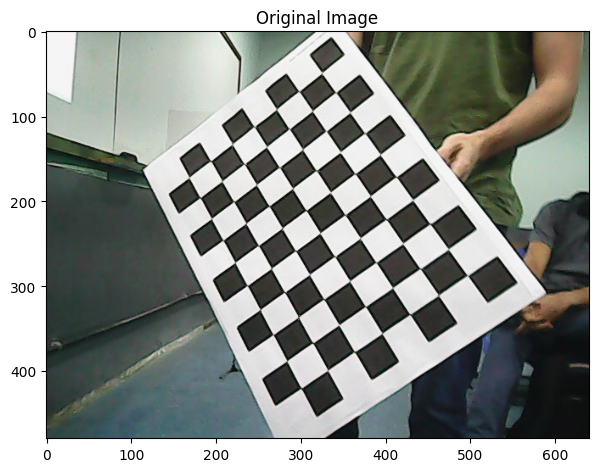

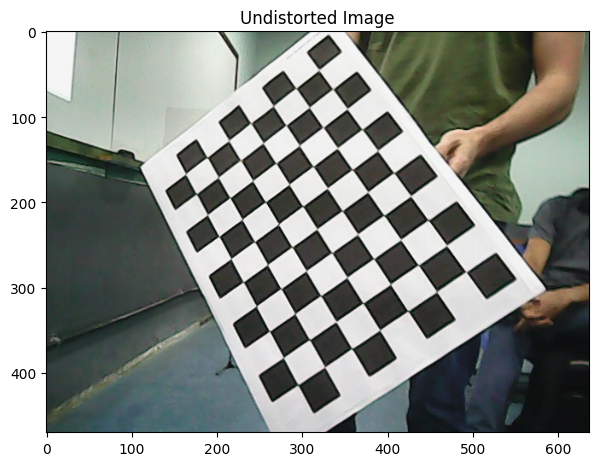

In [ ]:
# Refine camera calibration
img = cv2.imread('./imgs/my_photo-10.jpg')
# Convert to RGB to show with matplotlib.pyplot
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
h,  w = img.shape[:2]
print('Image size: ',h,' ',w)
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

print('New Matrix')
print(newcameramtx)

# Undistort one image as example
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

# When using Colab, we can not use cv2.imshow. So we are showing images
# with matplotlib.pyplot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Original Image")
plt.imshow(img)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Undistorted Image")
plt.imshow(dst)

#cv2.imshow('undistorted image',dst)
#cv2.waitKey(10)

# Calculate the reprojection error
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], newcameramtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print ("Total reprojection error: ", mean_error/len(objpoints))

# Uncomment if you are showing images using cv2.imshow
#cv2.destroyAllWindows()



# Show Extrinsic Parameters
## Considering the calibration pattern fixed at the origin and moving the camera.

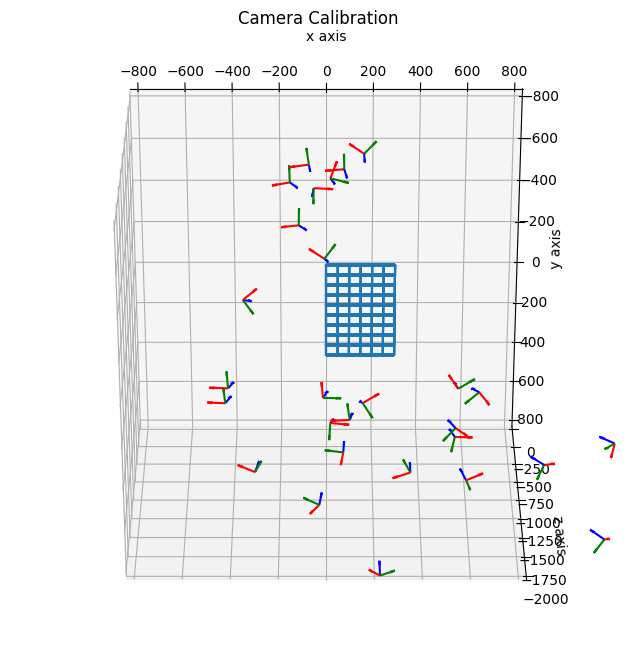

In [ ]:

# Initialize figure
axes0 = set_plot(limx=[-800,800],limy=[-800,800],limz=[-2000,0])
# Create base vector values
e1 = np.array([[1],[0],[0]]) # X
e2 = np.array([[0],[1],[0]]) # Y
e3 = np.array([[0],[0],[1]]) # Z

pos = np.zeros(transl.shape)

# Plot camera frames considering that the calibration patern is on the XY-plane and Z=0
for i in range(rot.shape[1]):  #

    R,_ = cv2.Rodrigues(rot[:,i])
    pos[:,i] = -np.dot(R.T,transl[:,i])
    e1_rotated = np.dot(R.T,e1)
    e2_rotated = np.dot(R.T,e2)
    e3_rotated = np.dot(R.T,e3)
    base_rotated = np.hstack((e1_rotated,e2_rotated,e3_rotated))
    axes0 = draw_arrows(pos[:,i],base_rotated,axes0,80)

# Plot the calibration pattern as it was fixed and all the
# relative positions of the camera
X,Y = np.meshgrid(objp[:,0],objp[:,1])
Z = np.zeros(X.shape)


axes0.plot_wireframe(X,Y,Z)
axes0.set_ylabel("y axis")
axes0.set_zlabel("z axis")

axes0.view_init(elev=-61,azim=-90)




##Considering the camera fixed at the origin and moving the calibration pattern

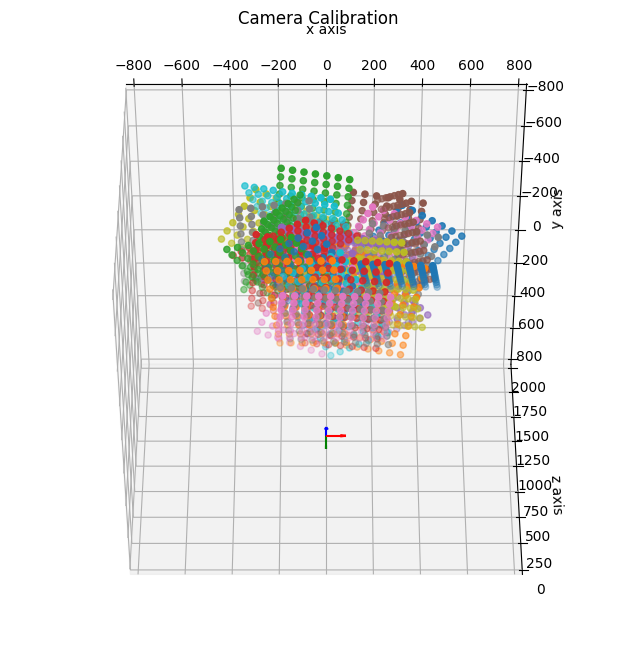

In [ ]:
# Initialize figure
axes1 = set_plot(limx=[-800,800],limy=[-800,800],limz=[0,2000])
base_cam = np.hstack((e1,e2,e3))
axes1 = draw_arrows([0,0,0],base_cam,axes1,80)

calib_points = objp.T
# Plot calibration patter considering the camera fixed at (0,0,0)
for i in range(rot.shape[1]):

    R,_ = cv2.Rodrigues(rot[:,i])
    Xrot = np.dot(R[0,:],calib_points) + transl[0,i]
    Yrot = np.dot(R[1,:],calib_points) + transl[1,i]
    Zrot = np.dot(R[2,:],calib_points) + transl[2,i]
    axes1.scatter(Xrot,Yrot,Zrot)

axes1.set_ylabel("y axis")
axes1.set_zlabel("z axis")


axes1.view_init(elev=-45,azim=-90)




plt.show()

